## Setup

This is my first model development pipeline by my hands. I know I still have much to improve, but hope this is a good starting point.

In [145]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gauravtopre/bank-customer-churn-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bank-customer-churn-dataset' dataset.
Path to dataset files: /kaggle/input/bank-customer-churn-dataset


In [146]:
import pandas as pd

df = pd.read_csv(f'{path}/Bank Customer Churn Prediction.csv')

In [147]:
df

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


First of all, we're dropping the column 'customer_id'. It has absolutely nothing to teach to the algorithm, and is going to overfit the model and distort the predictions.

In [148]:
df = df.drop('customer_id', axis=1)

In [149]:
df.columns

Index(['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary',
       'churn'],
      dtype='object')

The next step is to split the data into two groups: x (which contains features used to predict) and y (target variable, the class we want to predict)

In [150]:
X = df[['credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary']]
y = df['churn']

In [151]:
columns = X.columns

Now, we're going to use One-Hot Encoding to handle the categorical columns. All the categorical columns have low cardinality, so I'm encoding them all at once, even before the set between train and test.

In [152]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

ohe = make_column_transformer(
    (OneHotEncoder(drop='if_binary', sparse_output=False), ['country', 'gender']),
    remainder='passthrough'
)

In [153]:
X = ohe.fit_transform(X)

In [154]:
type(X)

numpy.ndarray

In [155]:
columns = ohe.get_feature_names_out(columns)

In [156]:
X = pd.DataFrame(X, columns=columns)
X

,onehotencoder__country_France,onehotencoder__country_Germany,onehotencoder__country_Spain,onehotencoder__gender_Male,remainder__credit_score,remainder__age,remainder__tenure,remainder__balance,remainder__products_number,remainder__credit_card,remainder__active_member,remainder__estimated_salary
0,1.0,0.0,0.0,0.0,619.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88
1,0.0,0.0,1.0,0.0,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58
2,1.0,0.0,0.0,0.0,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57
3,1.0,0.0,0.0,0.0,699.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63
4,0.0,0.0,1.0,0.0,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.0,0.0,1.0,771.0,39.0,5.0,0.00,2.0,1.0,0.0,96270.64
9996,1.0,0.0,0.0,1.0,516.0,35.0,10.0,57369.61,1.0,1.0,1.0,101699.77
9997,1.0,0.0,0.0,0.0,709.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58
9998,0.0,1.0,0.0,1.0,772.0,42.0,3.0,75075.31,2.0,1.0,0.0,92888.52


## Train-test split

In [157]:
SEED = 133

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=SEED)

Although it is common (and often required) to use a scaler, it doesn't mean I have to. In this case, we'll be using a RandomForest model, which does not need scaled input data, as it is not sensitive to feature magnitude.

## Model development pipeline

### Baseline
*Using a Dummy Classifier to know what's the minimum a model should do*

In [159]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.796

- 79.65% of the cases are non-churn;
- The rest 20.35% are churn cases, thus the dummy classifier fails to recognize them. So, the recall is zero.

### Model training and tuning

#### Step 1

In [160]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [161]:
from sklearn.model_selection import cross_validate, StratifiedKFold

Creating the cross-validation object using StratifiedKFold

In [162]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [164]:
cv_results = cross_validate(model, X_train, y_train, cv=cv)
cv_results

{'fit_time': array([1.30344439, 1.08649826, 0.88901567, 0.92628527, 0.89285541]),
 'score_time': array([0.04190111, 0.03033495, 0.03168535, 0.02818966, 0.03317976]),
 'test_score': array([0.85955882, 0.85808824, 0.85441176, 0.86911765, 0.84779412])}

In [165]:
cv_results['test_score'].mean()

np.float64(0.8577941176470588)

In [163]:
model.score(X_train, y_train)

1.0

The model shows an extremely high (100%) accuracy rate inside the train set, but when validated, it decays very much. This is a classic sign of **overfitting**, which is, in this case, caused by the excessive adaptation of the trees to that specific train conjunct, absorbing that set's background noise.

In [166]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [167]:
predictions = model.predict(X_val)

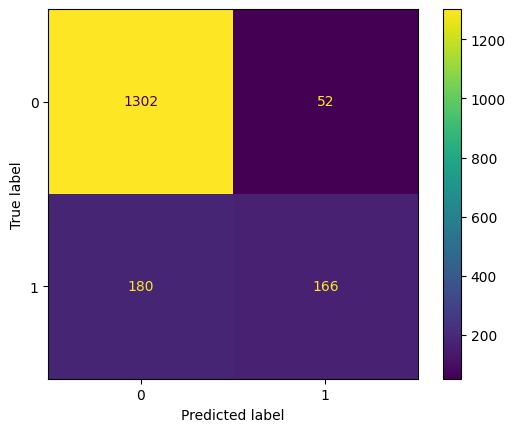

In [168]:
confusion = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, predictions))
confusion.plot();

In [169]:
from sklearn.metrics import recall_score, precision_score

print(f'Precision: {precision_score(y_val, predictions)*100:.4f}%')
print(f'Recall: {recall_score(y_val, predictions)*100:.4f}%')

Precision: 76.1468%
Recall: 47.9769%


Furthermore, the model struggles to detect the least frequent class (1 -> churn). Recall is only 47%. This indicates we have to use some sort of weight balancing, like oversampling or undersampling. I'm firstly going to use the built-in weight balancing method of the RandomForest model.

When there are high-value clients, it is better for the bank to identify churn cases than to know when a customer is going to stay. The opposite thing happens in the case of casual banking users. It would also be bad to target all of them as potential "churners" or "certainly non-churners", so we need to find a balance between precision and recall, because:
- It is expensive to the company to offer benefits to customers that aren't leaving
- And missing to offer benefits to clients that will leave is bad too, resulting in revenue loss

To pursue this equilibrium, I'll use F1-score as the main metric.

In [170]:
from sklearn.metrics import f1_score

f'F1-score: {f1_score(y_val, predictions)*100:.4f}%'

'F1-score: 58.8652%'

#### Step 2

In [207]:
model = RandomForestClassifier(max_depth=10, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10)

In [172]:
cv_results = cross_validate(model, X_train, y_train, cv=cv)
cv_results

{'fit_time': array([0.71799493, 0.73699784, 0.72788215, 0.75302052, 0.73674226]),
 'score_time': array([0.02495193, 0.02590156, 0.02407146, 0.02542019, 0.0255487 ]),
 'test_score': array([0.84117647, 0.84191176, 0.83161765, 0.85220588, 0.84117647])}

In [208]:
predictions = model.predict(X_val)

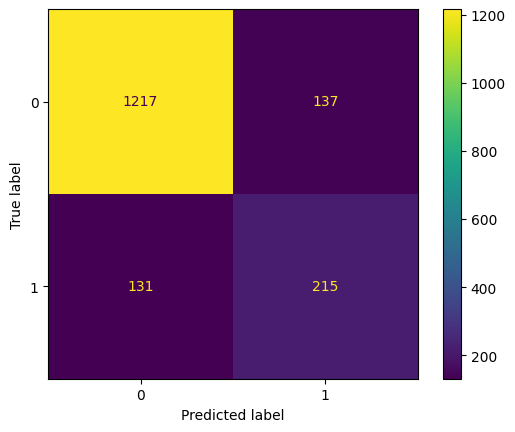

In [209]:
ConfusionMatrixDisplay(confusion_matrix(y_val, predictions)).plot();

The amount of false negatives (FN) is lower and that of true positives (TP) is now higher. In compensation of this fact, the quantity of false positives (FP) increased in 132%.

FN -> -30.9%

TP -> +36.36%

FP -> +132.87%

In [175]:
f1_score(y_val, predictions)

0.6008708272859217

In [176]:
print(f'Precision: {precision_score(y_val, predictions)*100:.4f}%')
print(f'Recall: {recall_score(y_val, predictions)*100:.4f}%')

Precision: 60.3499%
Recall: 59.8266%


If the clients are highly valuable ones, or the retention incentives are reasonably affordable, then the extreme increase in the FP amount may be tolerable. Otherwise, we are in need of lowering the FP index, but mantaining (at least partially) the improviments in the FN and TP rates. I'll do this by increasing the `min_samples_leaf` parameter.

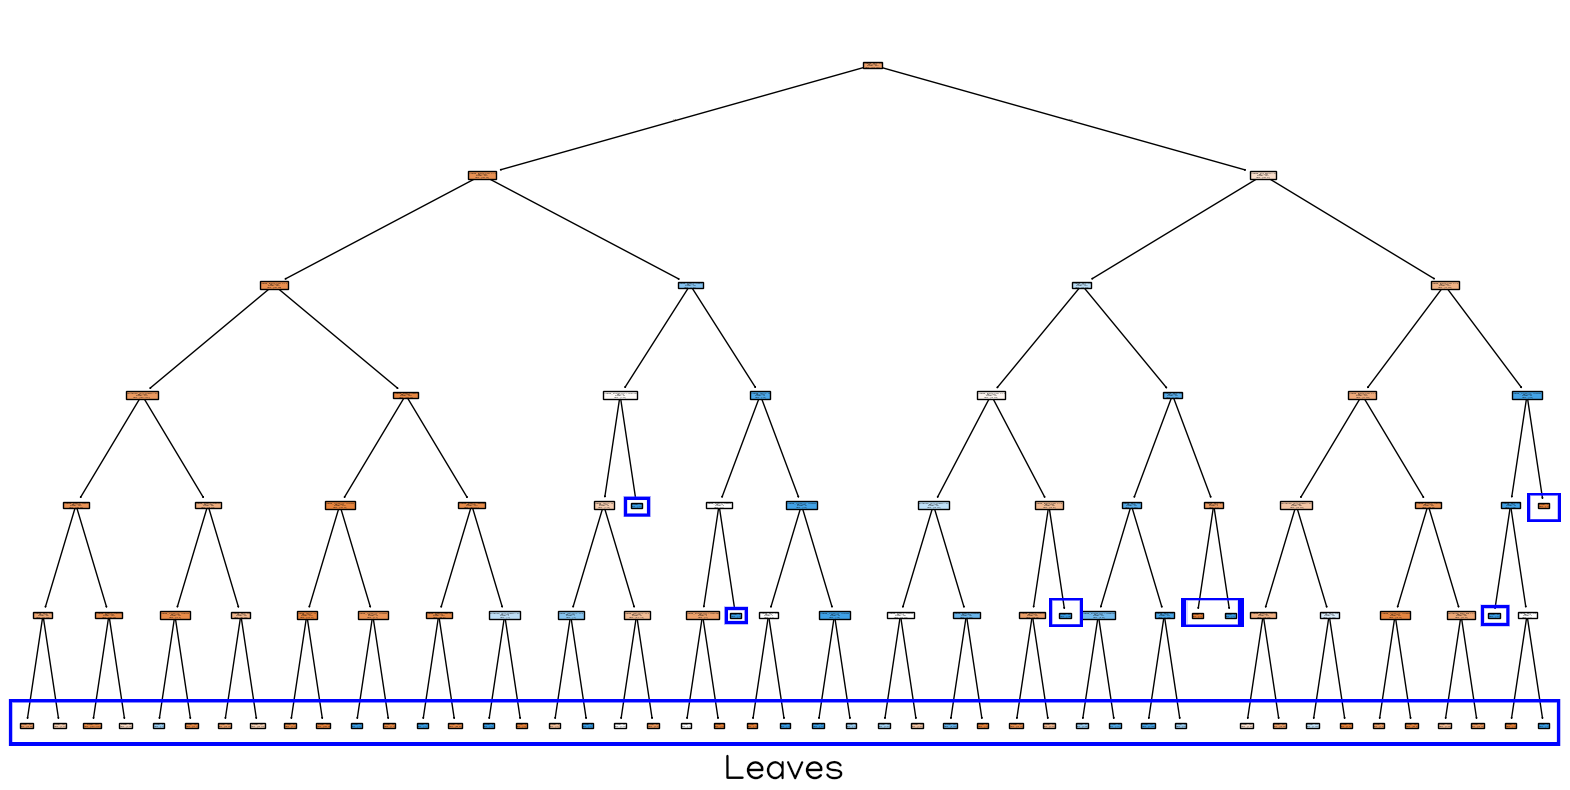

Leaves are the terminal nodes of the trees. When the number of samples per leaf is low, the tree itself is adjusted to the specific context of the train set. Increasing the minimum number of samples required to the tree to create a new node will reduce the amount of FPs while mantaining a part of the FN and TP improvements.

I'll also modify some other parameters to search for the best optimization bonds.

In [210]:
model = RandomForestClassifier(max_depth=13, class_weight='balanced', min_samples_leaf=4, min_samples_split=4)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=13,
                       min_samples_leaf=4, min_samples_split=4)

In [178]:
cv_accuracy = cross_validate(model, X_train, y_train, cv=cv)
mean_accuracy = cv_accuracy['test_score'].mean()
cv_accuracy

{'fit_time': array([0.98192096, 1.11410475, 0.94201875, 0.76086307, 0.7451427 ]),
 'score_time': array([0.03406072, 0.0355041 , 0.02727675, 0.02816558, 0.02720618]),
 'test_score': array([0.84779412, 0.84044118, 0.84485294, 0.85294118, 0.84411765])}

In [179]:
cv_f1 = cross_validate(model, X_train, y_train, cv=cv, scoring='f1')
mean_f1 = cv_f1['test_score'].mean()
cv_f1

{'fit_time': array([0.75515342, 0.77342916, 0.75548077, 0.7974627 , 0.76980114]),
 'score_time': array([0.02913022, 0.0303843 , 0.02976537, 0.0300293 , 0.0296979 ]),
 'test_score': array([0.64197531, 0.60707635, 0.60853432, 0.65232975, 0.61121157])}

In [180]:
print(f'Accuracy: {mean_accuracy*100:.4f}%')
print(f'F1-score: {mean_f1*100:.4f}%')

Accuracy: 84.6029%
F1-score: 62.4225%


In [211]:
predictions = model.predict(X_val)

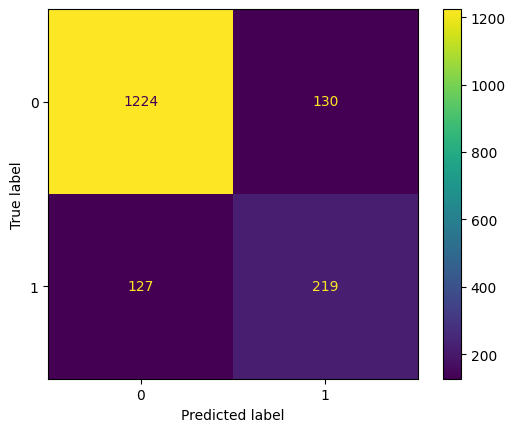

In [212]:
confusion = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions))
confusion.plot();

Comparing to the previous combination of parameters, this model is better, with a F1-score of 0.6 to 0.62

## Testing

In [213]:
predictions = model.predict(X_test)

In [184]:
f1_score(y_test, predictions)

0.6245847176079734

In [185]:
print(f'Precision: {precision_score(y_test, predictions)*100:.4f}%')
print(f'Recall: {recall_score(y_test, predictions)*100:.4f}%')

Precision: 63.5135%
Recall: 61.4379%


In [203]:
f'Accuracy: {model.score(X_test, y_test)*100:.4f}%'

'Accuracy: 84.9333%'

## Exporting

The model has still much to improve, but I won't pretend I understand it all ─ the details of the gears underneath ─ and try to increase the model's metrics with techniques I don't yet master or even realize how they work.

So, I'm stopping the tuning right here, and proceeding to the model export stage of the pipeline.

In [186]:
import pickle

In [187]:
with open('model.pkl', 'wb') as file:
  pickle.dump(model, file)

In [188]:
with open('model_ohe.pkl', 'wb') as file:
  pickle.dump(ohe, file)